In [1]:
!pip install mxnet-cu101mkl

     |████████████████████████████████| 587.7MB 32kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [0]:
from mxnet import gluon

In [3]:
train_imgs = gluon.data.vision.FashionMNIST(train = True)
test_imgs = gluon.data.vision.FashionMNIST(train = False)

In [0]:
X, y = train_imgs[:18]


In [0]:
import matplotlib.pyplot as plt
import sys

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [0]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

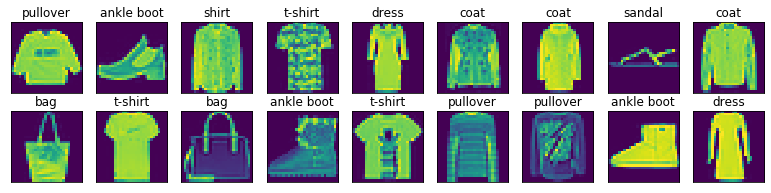

In [7]:

X, y = train_imgs[:18]
show_images(X.squeeze(axis = -1), 2, 9, titles=get_fashion_mnist_labels(y));

In [0]:
def get_dataloader_workers(num_workers=4):
    # 0 means no additional process is used to speed up the reading of data.
    if sys.platform.startswith('win'):
        return 0
    else:
        return num_workers

In [0]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load into memory."""
    dataset = gluon.data.vision
    trans = [dataset.transforms.Resize(resize)] if resize else []
    trans.append(dataset.transforms.ToTensor())
    trans = dataset.transforms.Compose(trans )
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans)
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans)
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                  num_workers=get_dataloader_workers(), ),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                  num_workers=get_dataloader_workers()))

In [0]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

28 x 28 images => 784 1D vectors.
treat each pixel as a feature

In [0]:
import mxnet as mx

num_inputs = 784
num_outputs = 10

W = mx.nd.random.normal(0, 0.01, (num_inputs, num_outputs))
b = mx.nd.zeros(num_outputs)


In [0]:
W.attach_grad()
b.attach_grad()

In [0]:
def softmax(X):

  X_exp = mx.nd.exp(X)

  row_sum = X_exp.sum(axis = 1, keepdims = True)

  return X_exp / row_sum

In [0]:
def net(X):
    return softmax(mx.nd.dot(X.reshape(-1, num_inputs), W) + b)

In [0]:

def accuracy(y_hat, y):
    if y_hat.shape[1] > 1:
        return ((y_hat.argmax(axis=1) == y.astype('float32')).sum()).astype('float32')
    else:
        return ((y_hat.astype('int32') == y.astype('int32')).sum()).astype('float32')

In [0]:
def cross_entropy(y_hat, y):
    return - mx.nd.log(y_hat[mx.nd.arange(len(y_hat)), y])

In [0]:
def sgd(parameters, lr, batch_size):

  """
  Stochastic gradient descent

  parameters: model parameters
  lr : learning rate
  batch_Size : mini batch size
  returns: updated parameters  
  """
  for param in parameters:
    param[:] = param - lr * param.grad / batch_size

In [0]:
class Accumulator:

  def __init__(self, n):

    self.data = [0.0] * n

  def add(self, *args):

    
    self.data = [a+b for a, b in zip(self.data, args)]

  def reset(self):

    self.data = [0] * len(self.data)

  def __getitem__(self,i):

    return self.data[i]



In [0]:
def eval_accuracy(net, data_iter):

  metric = Accumulator(2)

  for X,y in data_iter:
     metric.add(accuracy(net(X), y), y.size)

  return metric[0] / metric[1]

In [20]:
eval_accuracy(net, test_iter)



[0.0925]
<NDArray 1 @cpu(0)>

In [0]:
def train_epoch(net, train_iter, loss, updater):

  metric = Accumulator(3)


  for X,y in train_iter:

    with mx.autograd.record():
          y_hat = net(X)
          l = loss(y_hat , y)

    l.backward()

    updater(X.shape[0])

    metric.add((l.sum().astype(float)), accuracy(y_hat, y).astype(float), y.size)

    return float((metric[0]/metric[2]).asnumpy()), float((metric[1]/metric[2]).asnumpy())


      

In [0]:

import plotly.graph_objects as go
from IPython import display


class Animator():

  def __init__(self, x, y, z):

    self.fig = go.Figure()
    self.x = x
    self.y = y
    self.z = z

  def add_plot(self, x, y):

    self.x.append(x)

    

    self.y.append(y)

    





    self.fig.add_trace(go.Scatter(x=self.x, y= self.y,
                        mode='lines',
                        ))

    # self.fig.add_trace(go.Scatter(x=y.asnumpy(), y = y.grad.asnumpy(),
    #                     mode='lines+markers',
    #                     name='cosx'))


    self.fig.update_layout(title= self.z,
                            xaxis_title='Epoch',
                           yaxis_title='Metric'+self.z
                           
                           )

    display.clear_output(wait=True)
    display.display(self.fig)
    

    
  

In [0]:
def train( net, train_iter,test_iter, loss, epochs, optimizer):

  animator_trainloss = Animator([],[], "Train Loss")
  animator_trainaccuracy = Animator([], [], "Train Accuracy")
  animator_test_accuracy = Animator([],[],"Test Accuracy")

  for epoch in range(epochs):
    train_metrics = train_epoch(net, train_iter, loss, updater)
    test_acc = eval_accuracy(net, test_iter)
    animator_trainloss.add_plot(epoch+1, train_metrics[0] )
    #animator_trainaccuracy.add_plot(epoch+1, train_metrics[1])
    #animator_test_accuracy.add_plot(epoch+1, float(test_acc.asnumpy()))


In [45]:
num_epochs, lr = 10, 0.1

def updater(batch_size):
    sgd([W, b], lr, batch_size)

train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [47]:
num_epochs, lr = 10, 0.1

def updater(batch_size):
    sgd([W, b], lr, batch_size)

train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [70]:
num_epochs, lr = 10, 0.1

def updater(batch_size):
    sgd([W, b], lr, batch_size)


train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

Predictions

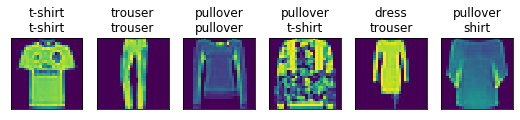

In [71]:
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y.asnumpy())
    preds = get_fashion_mnist_labels((net(X).argmax(axis=1).asnumpy()))
    titles = [true+'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape(n, 28, 28), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)